<a href="https://colab.research.google.com/github/nomadicsenseis/ViT_transfer_learning/blob/main/Transfer_learning_on_ViT_for_cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

On my Vision Transformer implementation https://github.com/nomadicsenseis/VisionTransformer, I showed how transfer learning is a reasonable approach for many of the problems in computer vision out there. 

Just like working with YOLO (latest version as of today being YOLOv8), there are many pretrained transformers on large datasets such as ImageNet that can be used as "common sense" baseline for many of the images used in more tecchnical fields. 

For example, if we were to create a model that detects melanoma on a picture of a patient's arm, we'd first have to teach the model to distinguish the arm from its background, and then, we would have to teach it to detect the actual melanoma. 

That is precisely why transfer learning is so usefull. In a way, the model already knows to distinguish between the arm and its background, and we are teaching it to distinguish melanoma withing different patologies on a human body.

In [ ]:
# General
import os, pickle
from pathlib import Path
from tqdm import tqdm

# Data manipulation
import pandas as pd
import numpy as np
from random import sample, shuffle, randint
from sklearn import metrics, model_selection
from math import ceil

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Image manipulation
import PIL, cv2
from skimage.io import imread, imshow

# Visualizations
import matplotlib as plt
import matplotlib.patches as patches
import seaborn as sns

# Matplotlib options
plt.rcParams['font.size']=14

# DL libraries

In [ ]:
!pip install kaggle

# Set the Kaggle API credentials (API key from your Kaggle account)
import os
os.environ['KAGGLE_USERNAME'] = 'diegoriveralopezbrea'
os.environ['KAGGLE_KEY'] = '74024c1cc931216df2a62050c7b85c52'

# Download the dataset
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000





Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
100% 5.20G/5.20G [04:52<00:00, 21.4MB/s]
100% 5.20G/5.20G [04:52<00:00, 19.1MB/s]
unzip:  cannot find or open kmader/skin-cancer-mnist-ham10000.zip, kmader/skin-cancer-mnist-ham10000.zip.zip or kmader/skin-cancer-mnist-ham10000.zip.ZIP.


In [ ]:
# Extract the ZIP file
!unzip -q skin-cancer-mnist-ham10000.zip

replace HAM10000_images_part_1/ISIC_0024306.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#Dataset

The dataset (HAM10000) covers 10015 dermatoscopic images over different populations and throughout various lessions:

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T

"Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).
More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesion_id-column within the HAM10000_metadata file.

Due to upload size limitations, images are stored in two files:

* HAM10000_images_part1.zip (5000 JPEG files)
* HAM10000_images_part2.zip (5015 JPEG files)
"

So the first step is to load the dataset. I have uploaded it to my Google Drive, but the dataset can also be found in Kaggle.

In [ ]:
import os
import shutil
from pathlib import Path

# Specify the paths of the dataset folders in Google Drive
dataset_folder1_path = '/content/HAM10000_images_part_1'
dataset_folder2_path = '/content/HAM10000_images_part_2'
metadata_path = '/content/HAM10000_metadata.csv'

# Specify the path where you want to copy the unified dataset in Colab
colab_dataset_path = '/content/data/HAM10000'
colab_metadata_path = '/content/metadata'

# Create the unified dataset folder in Colab
os.makedirs(colab_dataset_path, exist_ok=True)
os.makedirs(colab_metadata_path, exist_ok=True)

# Copy files from folder1 to the unified dataset folder
for filename in os.listdir(dataset_folder1_path):
    src = os.path.join(dataset_folder1_path, filename)
    dst = os.path.join(colab_dataset_path, filename)
    shutil.copy(src, dst)

# Copy files from folder2 to the unified dataset folder
for filename in os.listdir(dataset_folder2_path):
    src = os.path.join(dataset_folder2_path, filename)
    dst = os.path.join(colab_dataset_path, filename)
    shutil.copy(src, dst)

# Copy metadata files from drive to the colab runtime
shutil.copy(metadata_path, colab_metadata_path)

'/content/metadata/HAM10000_metadata.csv'

In [ ]:
csv_path = '/content/metadata/HAM10000_metadata.csv'
df_data=pd.read_csv(csv_path)
df_data.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

#Utils

In [ ]:
def bar_plt(y, x, title):
    sns.barplot(y=y, x=x, palette="dark")
    plt.pyplot.xticks(rotation=60, fontsize=11)
    plt.pyplot.yticks(fontsize=14)
    plt.pyplot.title(title, fontsize=14, pad=20)

In [ ]:
def show_examples(df, col, n_samples = 5):
    "Show `n_samples` of each type of value in `col` of dataframe `df`"
    groups = df.sort_values([col]).groupby(col)
    n_rows = len(groups)
    fig, m_axs = plt.pyplot.subplots(n_rows, n_samples, figsize = (3*n_samples, 2*n_rows))
    for n_axs, (type_name, type_rows) in zip(m_axs,groups):
        n_axs[0].set_title(type_name)
        for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples).iterrows()):
            c_ax.imshow(imread(c_row['path']))
            c_ax.axis('off')

#EDA

In [ ]:
# Convert labels to complete disease names (thanks to kaggle.com/ingbiodanielh/skin-cancer-classification-with-resnet-50-fastai)
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df_data.dx=df_data.dx.astype('category',copy=True)
df_data['label']=df_data.dx.cat.codes # Convert the labels to numbers
df_data['lesion_type']= df_data.dx.map(lesion_type_dict)
df_data.head()

lesion_id      image_id   dx dx_type   age   sex localization  label  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp      2   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp      2   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp      2   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp      2   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear      2   

         lesion_type  
0  Benign keratosis   
1  Benign keratosis   
2  Benign keratosis   
3  Benign keratosis   
4  Benign keratosis

In [ ]:
# create key relating label to lesion_type
label_list = df_data['label'].value_counts().keys().tolist()
lesion_list = df_data['lesion_type'].value_counts().keys().tolist()
label_to_lesion = dict(zip(label_list, lesion_list))
label_to_lesion

{5: 'Melanocytic nevi',
 4: 'Melanoma',
 2: 'Benign keratosis ',
 1: 'Basal cell carcinoma',
 0: 'Actinic keratoses',
 6: 'Vascular lesions',
 3: 'Dermatofibroma'}

In [ ]:
#Lets get the images.
data_path=Path('/content/data/HAM10000')

df_data['path'] = [Path(data_path/f'{fn}.jpg') for fn in df_data.image_id]

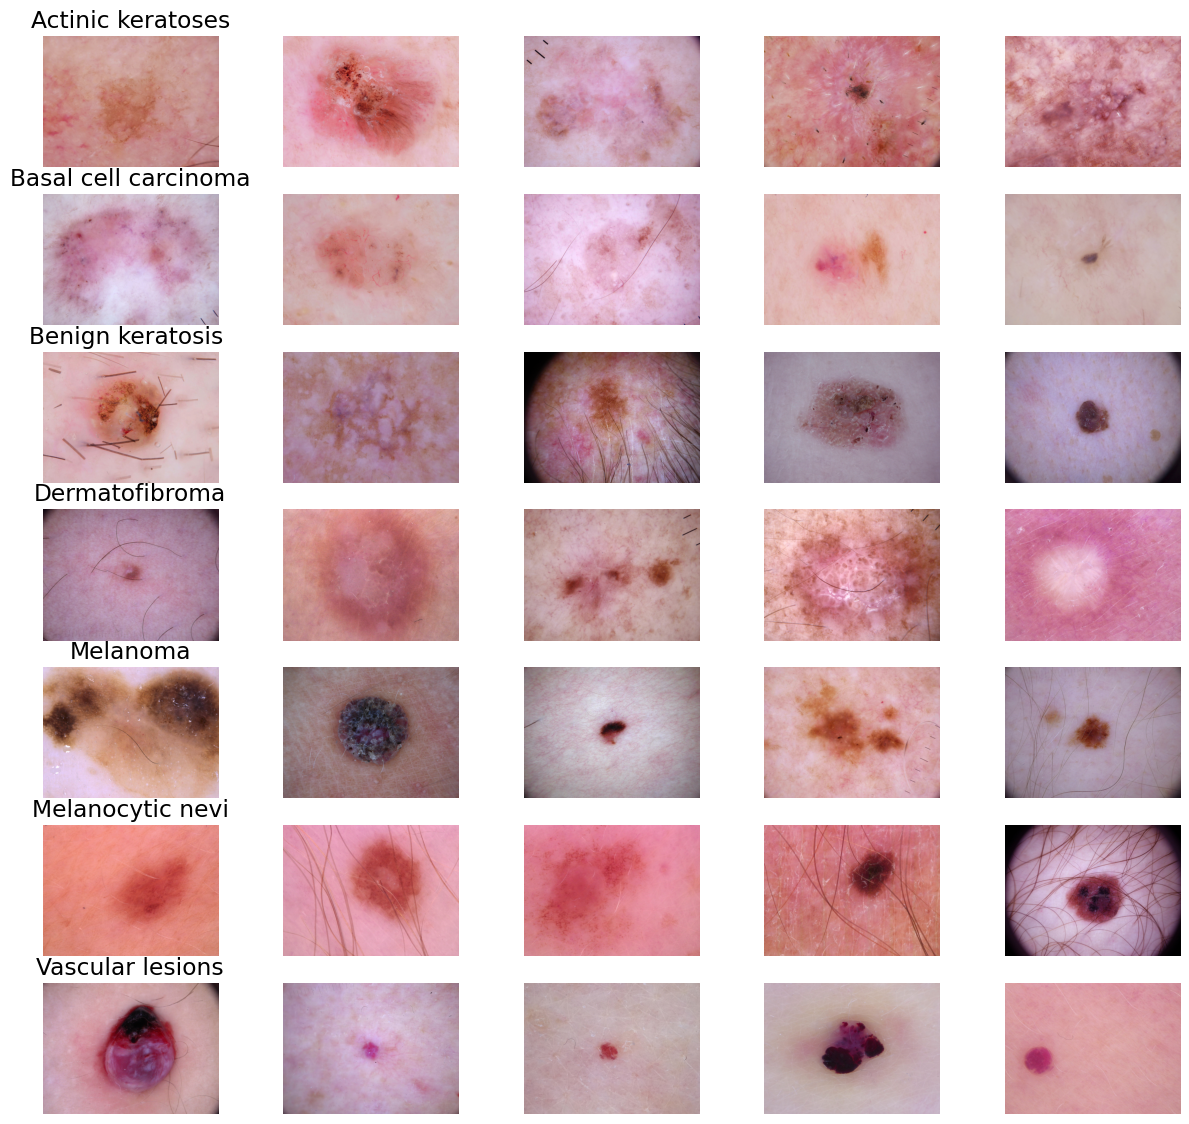

In [ ]:
# some examples of each lesion
show_examples(df_data, 'lesion_type')

There is some aditional metadata, lets take a look at what we have got left:

In [ ]:
df_data.iloc[0]

lesion_id                                   HAM_0000118
image_id                                   ISIC_0027419
dx                                                  bkl
dx_type                                           histo
age                                                80.0
sex                                                male
localization                                      scalp
label                                                 2
lesion_type                           Benign keratosis 
path            /content/data/HAM10000/ISIC_0027419.jpg
Name: 0, dtype: object

Alright: age, sex and location. Is there any relevant missing data?

In [ ]:
pd.isnull(df_data).sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
label            0
lesion_type      0
path             0
dtype: int64

We have some missing patient ages, which we can probably ignore. Lets take a look and see if we can get some information from them.

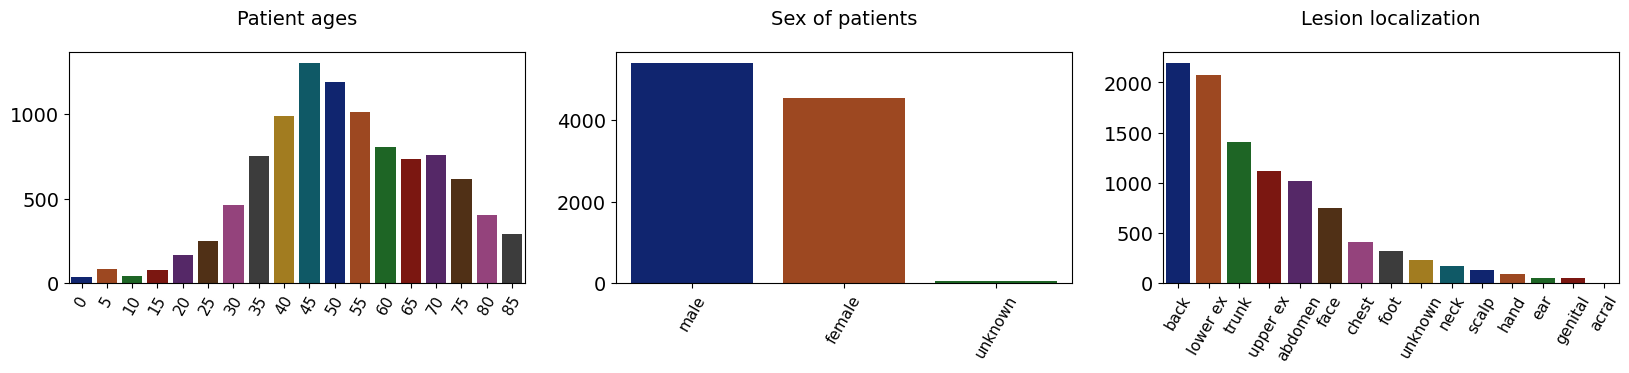

In [ ]:
# plot histogram of patient ages
fig, axes = plt.pyplot.subplots(1, 3, figsize=(20, 3))
plt.pyplot.subplot(1, 3, 1)
data = df_data['age'].value_counts()
bar_plt(data.tolist(), [int(x) for x in data.keys().tolist()], title='Patient ages')

# plot bar chart of patients sex
plt.pyplot.subplot(1, 3, 2)
data = df_data['sex'].value_counts()
bar_plt(data.tolist(), data.keys().tolist(), title='Sex of patients')

# plot barchart of localization of lesion on the body
plt.pyplot.subplot(1, 3, 3)
data = df_data['localization'].value_counts()
bar_plt(data.tolist(), [x[:8] for x in data.keys().tolist()], title='Lesion localization')

#Preprocessing

As for the preprocessing, I am going to follow the work done in https://colab.research.google.com/github/hallmx/DL_medical_imaging_cle-ai/blob/master/HAM10000_skin_lesion_classifier.ipynb#scrollTo=7IW7pnL6XXwq, but adapting the code to the preprocesing done in https://link.springer.com/article/10.1007/s11063-023-11204-5.

##Train-test split + duplicates

Split out a labelled test set (df_test).

When we check the lesion_id column we find that a lot of lesions have two or more different images associated with them. This is fine for training (where it acts as a form of data augmentation), but may falsify our validation and/or test results if images from the same lesion are in both the training AND validation/test sets.

In [ ]:
# get number of non-unique lesion_id's
def check_duplicates(df, col):
    unique_list = df.lesion_id.unique().tolist()
    num_duplicates = len(df) - len(unique_list)
    return num_duplicates

num_duplicates = check_duplicates(df_data, 'lesion_id')
print(f'Duplicate lesion_ids: {num_duplicates} out of {len(df_data)}')

Duplicate lesion_ids: 2545 out of 10015


"When Datta et al. [10] trained the dataset with different training-test splits, they found that 85% to 15% training and testing splits had better performance than 80% to 20% and 70% to 30% splits. In our experiment, 85% to 15% splits were used as well."

In [ ]:
test_set_fraction = 0.15

# randomly select the test set
df_train, df_test = model_selection.train_test_split(df_data, test_size=test_set_fraction)

# remove any duplicate images from the test set and check
df_test = df_test.drop_duplicates(subset='lesion_id', keep="first")
num_duplicates = check_duplicates(df_test, 'lesion_id')
print(f'Duplicate lesion_ids: {num_duplicates} out of {len(df_test)}')

# remove any lesions from the train set that are also in the test set
df_train = df_train[~df_train.lesion_id.isin(df_test.lesion_id)]

# finally check test and train dfs have no shared `lesion_ids` or `image_ids`
import collections
check_lesion_ids = df_test['lesion_id'].isin(df_train['lesion_id']).value_counts()    
check_image_ids = collections.Counter(df_test.image_id.isin(df_train.image_id))
print(f'Test/train overlap? lesion_id: {int(check_lesion_ids) != len(df_test)}, image_id: {check_image_ids[0] != len(df_test)}')

Duplicate lesion_ids: 0 out of 1435
Test/train overlap? lesion_id: False, image_id: False


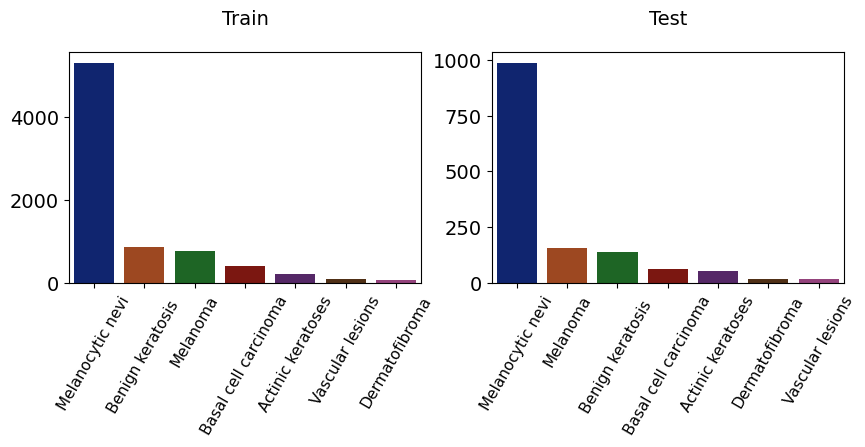

In [ ]:
# Check the balance of the train and test sets
fig, axes = plt.pyplot.subplots(1, 2, figsize=(10, 3))
for i, (df, title) in enumerate([(df_train, 'Train'), (df_test, 'Test')]):
    plt.pyplot.subplot(1,2,i+1)
    data = df['lesion_type'].value_counts()
    bar_plt(data.tolist(), data.keys().tolist(), title=title)

## Train-val split

In [ ]:
val_set_fraction = 0.15

# randomly select the test set
df_train, df_val = model_selection.train_test_split(df_train, test_size=val_set_fraction)

# remove any duplicate images from the val set and check
df_val = df_val.drop_duplicates(subset='lesion_id', keep="first")
num_duplicates = check_duplicates(df_val, 'lesion_id')
print(f'Duplicate lesion_ids: {num_duplicates} out of {len(df_val)}')

# remove any lesions from the train set that are also in the val set
df_train = df_train[~df_train.lesion_id.isin(df_val.lesion_id)]

# finally check val and train dfs have no shared `lesion_ids` or `image_ids`
import collections
check_lesion_ids = df_val['lesion_id'].isin(df_train['lesion_id']).value_counts()    
check_image_ids = collections.Counter(df_val.image_id.isin(df_train.image_id))
print(f'Val/train overlap? lesion_id: {int(check_lesion_ids) != len(df_val)}, image_id: {check_image_ids[0] != len(df_val)}')

Duplicate lesion_ids: 0 out of 1118
Val/train overlap? lesion_id: False, image_id: False


##Class rebalancing

"Class rebalancing is applied to the images of seven types of skin cancers in the training set for better classification performance. The class rebalancing is needed, as the dataset of dermoscopy images contains an imbalanced number across different classes. The dataset is processed by oversampling and undersampling to ensure all the classes have an equal number of images. Oversampling is applied to the image class in the training dataset with fewer images by applying Keras data augmentation methods, including random rotations of 180 degrees, width and height shifts of 0.1 fractions, random zooming ranges of 0.1, and random flipping both horizontally and vertically. The accuracy of the same model (ViTfSCD-B) applied to the HAM10000 dataset was compared with and without oversampling. The result showed the overall accuracy can be improved from 70.46 to 91.4%. We can see from sensitivity figures in Fig. 3 that, before oversampling, types with far fewer samples were underfitting compared with types with more samples (such as BKL and NV). However, after oversampling, each class acquired more balanced training. Accordingly, we used the oversampled HAM10000 dataset for all our experiments. Undersampling is conducted by removing duplicated images of the same skin lesion. Finally, the pixel values of the images are normalized to a 0–1 range."

On the original paper they made use of keras' ImageDataGenerator, but for the shake of originalitty and consistency (I will be using PyTorch's ViT) I will be making the augmentation in PyTorch.

In [ ]:
import torchvision.transforms as transforms

datagen = transforms.Compose([
    transforms.RandomRotation(180),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=0.25, scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
])


Here's the breakdown of the transformations:

* transforms.RandomRotation(180): Randomly rotates the image by 180 degrees.
* transforms.RandomAffine(...): Applies a random affine transformation to the image. The translate parameter specifies the maximum horizontal and vertical shift as fractions of the image size. The scale parameter determines the zooming range, where values less than 1.0 represent zooming in, and values greater than 1.0 represent zooming out.
* transforms.RandomHorizontalFlip(): Randomly flips the image horizontally with a probability of 0.5.
transforms.RandomVerticalFlip(): Randomly flips the image vertically with a probability of 0.5.
* transforms.ToTensor(): Converts the PIL image or NumPy array to a PyTorch tensor.

In [ ]:
# calculate an augmentation  multiplier for each class
counts = df_train['label'].value_counts()
aug_mults = [(max(counts)/3)//counts[i] for i, c in enumerate(counts)]
aug_mults.sort()
aug_dict = dict(zip(counts.keys(), aug_mults))
aug_dict

{5: 0.0, 2: 2.0, 4: 2.0, 1: 4.0, 0: 7.0, 6: 16.0, 3: 25.0}

In [ ]:
# add the multiplier to the training dataframe
df_train['aug_mult'] = df_train['label'].map(lambda x: int(aug_dict.get(x)))

In [ ]:
# create a new folder for augmented images
aug_dir = Path('/content/data/HAM10000_augmented')
os.mkdir(aug_dir)

In [ ]:
# for each row in `df_train`, generate 'aug_multplier' augmented images per `base_img` input and save in `aug_dir`
# images saved with filename `base-image-id` + `_0_`+ `number-augmented-image`+'.jpg'
from PIL import Image

for row in df_train.itertuples():
    inp_img = Image.open(row.path)  # PIL image
    
    id = row.image_id
    for i in range(row.aug_mult):
        transformed_img = datagen(inp_img)
        transformed_img.save(os.path.join(aug_dir, f"{id}_0_{i}.jpg"))
    

In [ ]:
#Get a list of all augmented pictures
aug_items_train=os.listdir('/content/data/HAM10000_augmented')

Num augmented images: 7714


lesion_id           image_id   dx dx_type  age  sex localization label  \
0  HAM_0005989  ISIC_0033123_0_15  NaN     NaN  NaN  NaN          NaN     6   
1  HAM_0007131   ISIC_0031692_0_1  NaN     NaN  NaN  NaN          NaN     0   
2  HAM_0001430   ISIC_0031088_0_0  NaN     NaN  NaN  NaN          NaN     2   
3  HAM_0007454   ISIC_0032214_0_1  NaN     NaN  NaN  NaN          NaN     4   
4  HAM_0002914  ISIC_0024904_0_14  NaN     NaN  NaN  NaN          NaN     6   

         lesion_type                                               path  \
0   Vascular lesions  /content/data/HAM10000_augmented/ISIC_0033123_...   
1  Actinic keratoses  /content/data/HAM10000_augmented/ISIC_0031692_...   
2  Benign keratosis   /content/data/HAM10000_augmented/ISIC_0031088_...   
3           Melanoma  /content/data/HAM10000_augmented/ISIC_0032214_...   
4   Vascular lesions  /content/data/HAM10000_augmented/ISIC_0024904_...   

  aug_mult  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN

Examples of augmented images (nb. each row contains augmented data from different lesions)


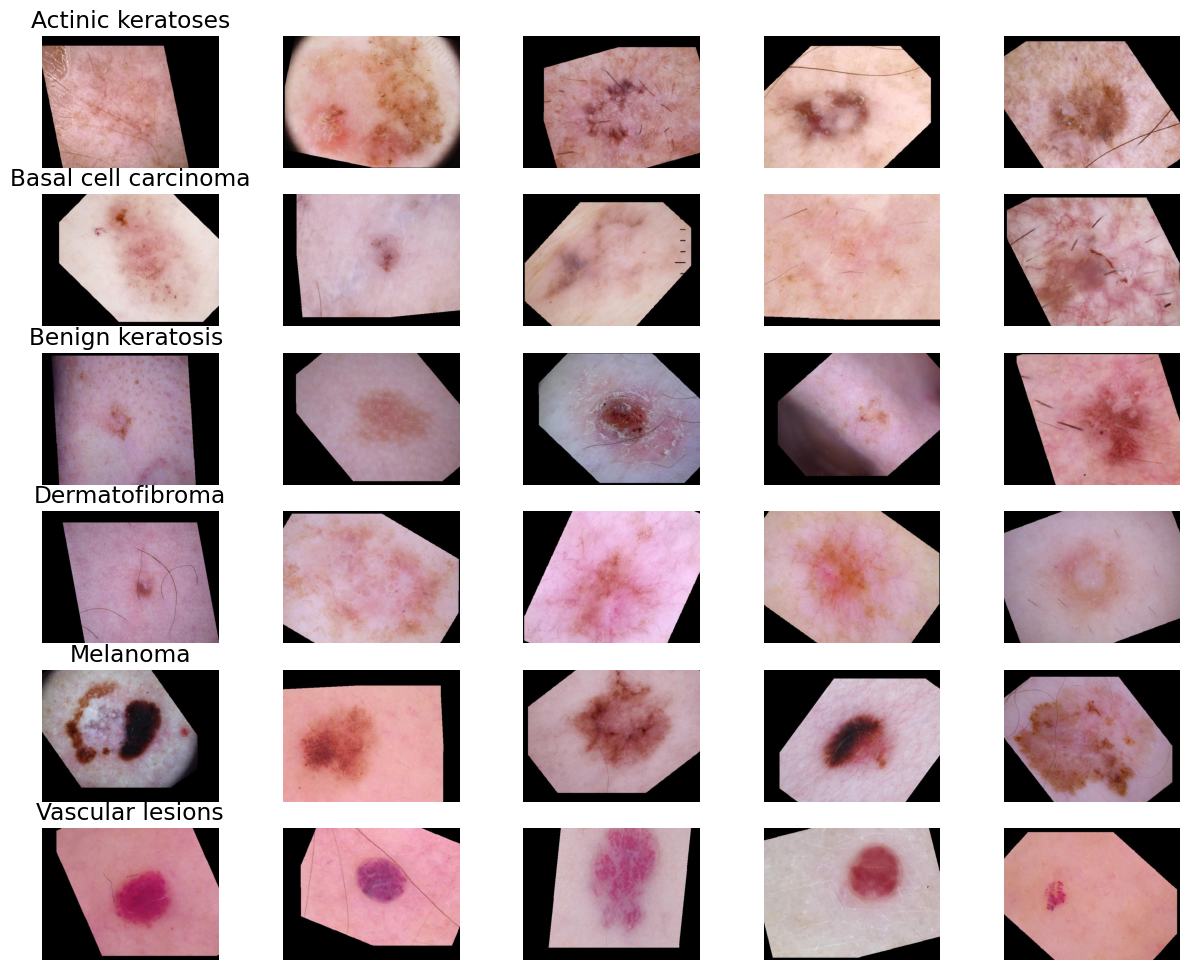

In [ ]:
# prepare a df from augmented image filenames (remember we encoded the base-image-id into the augmented image filename)
df_train_aug = pd.DataFrame(columns = df_train.columns)
df_train_aug['image_id'] = [x[:-4] for x in aug_items_train]
df_train_aug['path'] = ['/content/data/HAM10000_augmented/'+x for x in aug_items_train]

for i, row in enumerate(df_train_aug.itertuples()):
    id = row.image_id.split('_0_')[0]
    r = df_train.loc[df_train.image_id == id]
    df_train_aug.at[i, 'label'] = r.label.values[0]
    df_train_aug.at[i, 'lesion_id'] = r.lesion_id.values[0]
    df_train_aug.at[i, 'lesion_type'] = r.lesion_type.values[0]

    
print(f'Num augmented images: {len(df_train_aug)}')
display(df_train_aug.head())
print(f'Examples of augmented images (nb. each row contains augmented data from different lesions)')
show_examples(df_train_aug, 'lesion_type')

Num training images: 13776


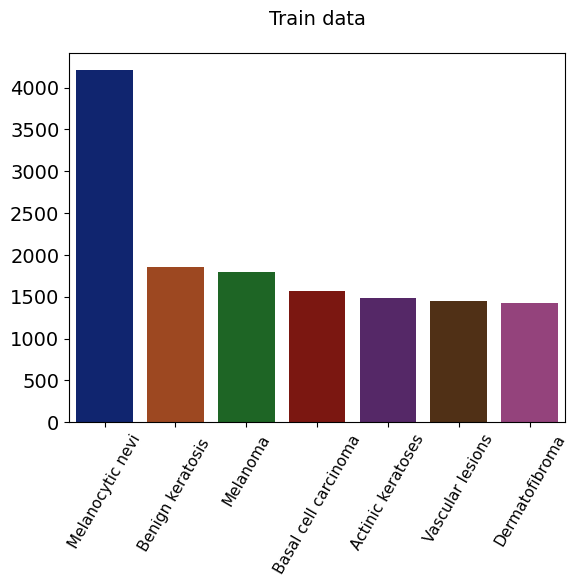

In [ ]:
# merge the original and augmented image dataframes
df_train_data = pd.concat([df_train, df_train_aug], ignore_index=True)
print(f'Num training images: {len(df_train_data)}')

# Check the balance of the train and test sets
data = df_train_data['label'].value_counts()
bar_plt(data.tolist(), [label_to_lesion[x] for x in data.keys().tolist()], title='Train data')

Though it is still very imbalanced, now there are more images of the minority classes.

#DataLoaders

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

##Organize data to read with ImageFolder

In [ ]:
import os
import shutil

train_dir = "/content/data/train"
val_dir = "/content/data/val"
test_dir = "/content/data/test"
image_dir = "/content/data/HAM10000"

# Create train, val and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Move images to val directory
for _, row in df_train_data.iterrows():
    image_id = row["image_id"]
    label = row["lesion_type"]
    src_path = row.path
    dest_path = os.path.join(train_dir, str(label), f"{image_id}.jpg")
    os.makedirs(os.path.join(train_dir, str(label)), exist_ok=True)
    shutil.copy(src_path, dest_path)

# Move images to test directory
for _, row in df_val.iterrows():
    image_id = row["image_id"]
    label = row["lesion_type"]
    src_path = os.path.join(image_dir, f"{image_id}.jpg")
    dest_path = os.path.join(val_dir, str(label), f"{image_id}.jpg")
    os.makedirs(os.path.join(val_dir, str(label)), exist_ok=True)
    shutil.copy(src_path, dest_path)

# Move images to test directory
for _, row in df_test.iterrows():
    image_id = row["image_id"]
    label = row["lesion_type"]
    src_path = os.path.join(image_dir, f"{image_id}.jpg")
    dest_path = os.path.join(test_dir, str(label), f"{image_id}.jpg")
    os.makedirs(os.path.join(test_dir, str(label)), exist_ok=True)
    shutil.copy(src_path, dest_path)




##Create dataloaders

In [ ]:
NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

"As mentioned above, the HAM10000 dataset was used for training and test data. The images were resized for the different methods: 384 × 384 for ViTfSCD, 299 × 299 for the IRv2 + SA, and 224 × 224 for the ResNet50 + SA, respectively."

So I will resize the images to 384. I will also apply the normalization of the pixeles that I didnt apply to the whole dataset.

In [ ]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224 #I tried using 384x384 but I think PyTorch's pretrained ViT only allows this size.

# Create transform pipeline for the batches
batch_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),    
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])
])           
print(f"Manually created transforms: {batch_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])
)


In [ ]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=val_dir,
    transform=batch_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fde5a4364a0>,
 ['0', '1', '2', '3', '4', '5', '6'])

#Pretrained ViT and transfer learning

In [ ]:
# The following requires torch v0.12+ and torchvision v0.13+
import torch
import torchvision
print(torch.__version__) 
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [ ]:
#Imports for Harvard PyTorch implementation
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
#pretrained_vit # uncomment for model output 

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:07<00:00, 49.0MB/s]


In [ ]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval() 

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

In [ ]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device
                               )

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9112 | train_acc: 0.6733 | test_loss: 0.6671 | test_acc: 0.7548
Epoch: 2 | train_loss: 0.6766 | train_acc: 0.7609 | test_loss: 0.6250 | test_acc: 0.7641
Epoch: 3 | train_loss: 0.6036 | train_acc: 0.7848 | test_loss: 0.6056 | test_acc: 0.7693
Epoch: 4 | train_loss: 0.5594 | train_acc: 0.7985 | test_loss: 0.6905 | test_acc: 0.7514
Epoch: 5 | train_loss: 0.5336 | train_acc: 0.8076 | test_loss: 0.6058 | test_acc: 0.7704
Epoch: 6 | train_loss: 0.5079 | train_acc: 0.8161 | test_loss: 0.6041 | test_acc: 0.7801
Epoch: 7 | train_loss: 0.4907 | train_acc: 0.8212 | test_loss: 0.6014 | test_acc: 0.7739
Epoch: 8 | train_loss: 0.4745 | train_acc: 0.8278 | test_loss: 0.6159 | test_acc: 0.7765
Epoch: 9 | train_loss: 0.4584 | train_acc: 0.8341 | test_loss: 0.5946 | test_acc: 0.7802
Epoch: 10 | train_loss: 0.4474 | train_acc: 0.8341 | test_loss: 0.6034 | test_acc: 0.7835


#Results

##Saving the model

In [ ]:
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

In [ ]:
save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="pretrained_vit_HAM10000.pth")

[INFO] Saving model to: models/pretrained_vit_HAM10000.pth


##Make test predictions

In [ ]:
def pred_and_plot_image(model: torch.nn.Module, 
                        dataset: torchvision.datasets.ImageFolder,
                        index: int,
                        transform = None,                        
                        class_names: List[str] = None, 
                        device: torch.device = device):
    """Makes a prediction on a target image from an ImageFolder dataset and plots the image with its prediction."""
    
    # 1. Get the image and label from the dataset at the specified index
    target_image, label = dataset[index]
    
    # 2. Transform if necessary
    if transform is not None:
        if isinstance(transform, transforms.Compose):
            target_image = transform(target_image)
        else:
            target_image = transform(target_image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

In [ ]:
pred_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),    
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
    transforms.ToPILImage()
]) 

In [ ]:
test_data = datasets.ImageFolder('/content/data/test', transform=pred_transforms)
test_data

Dataset ImageFolder
    Number of datapoints: 1435
    Root location: /content/data/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])
               ToPILImage()
           )

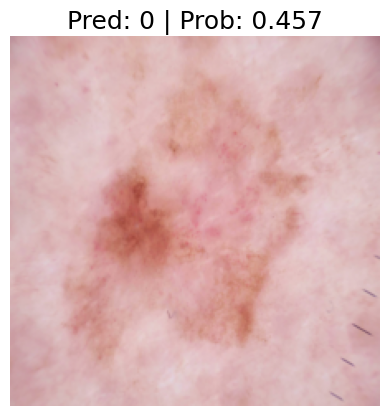

In [ ]:
# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    dataset=test_data,
                    index=1,
                    class_names=class_names,
                    transform=batch_transforms)

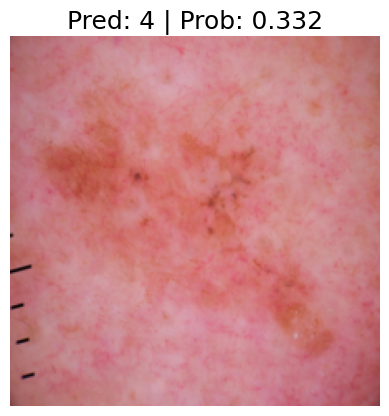

In [ ]:
# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    dataset=test_data,
                    index=285,
                    class_names=class_names,
                    transform=batch_transforms)

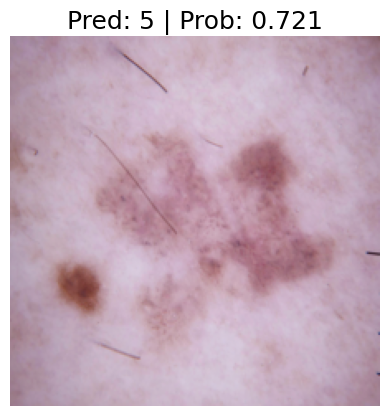

In [ ]:
# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    dataset=test_data,
                    index=134,
                    class_names=class_names,
                    transform=batch_transforms)

##General performance:

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def evaluate_model(model: torch.nn.Module,
                   dataset: torchvision.datasets.ImageFolder,
                   transform=None,
                   device: torch.device = device):
    """Applies inference and computes evaluation metrics over the entire dataset."""
    
    # Initialize variables for metrics
    total_samples = len(dataset)
    total_correct = 0
    total_tp = 0
    total_actual_pos = 0
    total_pred_pos = 0
    
    # Set model to evaluation mode
    model.eval()
    
    # Initialize empty lists for storing labels and predictions
    all_labels = []
    all_predictions = []
    
    # Iterate through the dataset
    for index in range(total_samples):
        # Get image and label from the dataset
        image, label = dataset[index]
        
        # Apply transformation if necessary
            # 2. Transform if necessary
        if transform is not None:
          if isinstance(transform, transforms.Compose):
            image = transform(image)
          else:
            image = transform(image)
        
        # Add an extra dimension to the image and send it to the target device
        image = image.unsqueeze(dim=0).to(device)
        
        # Perform inference on the image
        with torch.inference_mode():
            prediction = model(image)
        
        # Calculate prediction probabilities and predicted label
        prediction_probs = torch.softmax(prediction, dim=1)
        predicted_label = torch.argmax(prediction_probs, dim=1).item()
        
        # Update metrics
        total_correct += int(predicted_label == label)
        total_tp += int(predicted_label == label == 1)
        total_actual_pos += int(label == 1)
        total_pred_pos += int(predicted_label == 1)
        
        # Store labels and predictions
        all_labels.append(label)
        all_predictions.append(predicted_label)
    
    # Calculate evaluation metrics
    accuracy = total_correct / total_samples
    recall = total_tp / total_actual_pos
    precision = total_tp / total_pred_pos
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    # Print evaluation metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1_score:.4f}")
    
    # Create confusion matrix
    confusion_mat = confusion_matrix(all_labels, all_predictions)
    
    # Plot confusion matrix
    class_names = dataset.classes
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


Accuracy: 0.7847
Recall: 0.6290
Precision: 0.5342
F1 Score: 0.5778


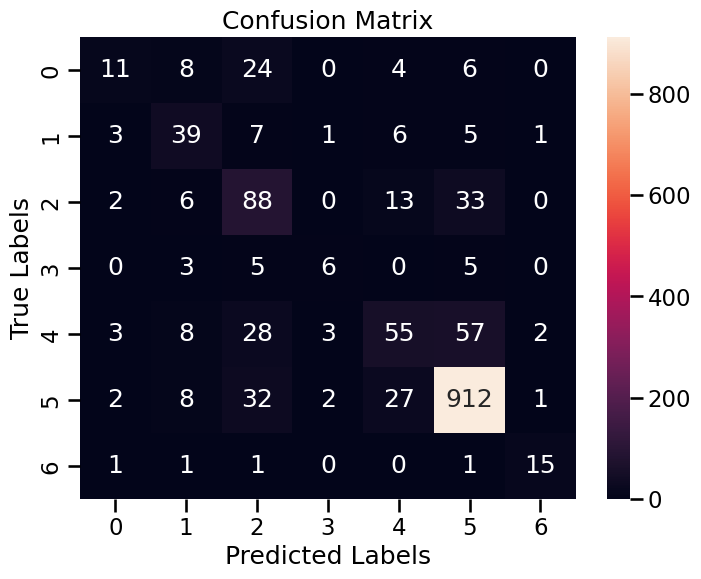

In [ ]:
evaluate_model(model=pretrained_vit,
                    dataset=test_data,
                    transform=batch_transforms)

There are several reasons that might explain why my performance is worse than the one mentioned in the paper:
1. The data augmentation. I dont like the rotations I see in there. They SHOULD be 0 OR 180 degrees. I can see othere angles and that generates the black areas on the training set. 

2. Size of the images. I am using 224 instead of 384 (maybe due to an incompality with the ViT that Im using from torch library).

3. Pretrained ViT. They might be using one larger/better than the one I am using. 

4. In the oversampling, I have implemented an augmenting facotr that might not be the same as they have. Also, this factor should not be implemented for the classes with it smaller than 1 (check).

5. I haven't done any downsampling to the most populated class.

6. Hyperparameter tunning of the tranfered training. I should probably explore the hyperspace a bit more.